<a href="https://colab.research.google.com/github/minnji88/DeepLearning2020/blob/master/5_3_%EC%82%AC%EC%A0%84_%ED%9B%88%EB%A0%A8%EB%90%9C_%EC%BB%A8%EB%B8%8C%EB%84%B7_%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

작은 이미지 데이터 셋에서 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 사전 훈련된 네트워크(pretrained network) 는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다.
여러 모델이 있지만 여기서는 VGG16 모델을 사용합니다.
사전 훈련된 네트워크는 2가지 방법으로 사용할 수 있습니다.

- 특성 추출(feature extraction)
- 미세 조정(fine tuning)

## 5.3.1 특성 추출
특성 추출 은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아 내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다.

- 합성곱 기반 층 : 합성곱과 풀링 층으로 구성
- 완전 연결 분류기

컨브넷의 특성 맵은 사진에 대한 일반적인 콘셉트의 존재 여부를 기록한 맵입니다.

분류기는 전체 사진에 어떤 클래스가 존재할 확률 정보 -> 훈련된 클래스 집합에 특화

완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 위치 정보를 가지고 있지 않음 

특정 합성곱 층에서 추출한 표현의 일반성 및 재사용성 수준은 모델에 있는 층의 깊이에 따라 달려있습니다.

- 하위 층 : 에지, 색깔, 질감 등 지역적이고 매우 일반적인 특성 맵
- 상위 층 : 강아지 눈, 고양이 귀와 같은 좀 더 추상적인 개념


ImageNet 데이터셋에서 훈련된 **VCG16** 네트워크에서 유용한 특성을 추출합니다. 그 후 특성으로 훈련을 진행합니다.VGG16 모델은 케라스 패키지로 존재하며 keras.applications 모듈에서 import 할 수 있습니다. 

In [1]:
!pip uninstall keras
!pip uninstall tensorflow

!pip install keras==2.3.1
!pip install tensorflow==2.2

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3
Uninstalling tensorflow-2.4.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 378kB 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- weights는 모델을 초기화할 가중치 체크포인트를 지정합니다.
- include_top은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
- input_shape은 네트워크에 주입할 이미지 텐서의 크기입니다.

In [3]:
# 코드 5-16 VGG16 합성곱 기반 층 만들기
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

최종 특성 맵의 크기는 (4, 4, 512)입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다.

## 1. 데이터 증식을 사용하지 않는 빠른 특성 추출

ImageDatagenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출합니다.
conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출합니다.
추출된 특성의 크기는 (samples, 4, 4, 512)이기에 완전 연결 분류기에 넣기 위해 (samples, 8192)크기로 펼칩니다.

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/COLAB/SAI/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

이제 여기서 완전 연결 분류기를 정의하고 저장된 데이터와 레이블을 사용하여 훈련합니다. 규제를 위해 드롭아웃을 사용합니다.

In [6]:
# 코드 5-18 완전 연결 분류기를 정의하고 훈련하기
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.5616 - acc: 0.7200 - val_loss: 0.4250 - val_acc: 0.8450
Epoch 2/30
2000/2000 [==============================] - 1s 256us/step - loss: 0.4130 - acc: 0.8220 - val_loss: 0.3575 - val_acc: 0.8670
Epoch 3/30
2000/2000 [==============================] - 1s 259us/step - loss: 0.3516 - acc: 0.8525 - val_loss: 0.3179 - val_acc: 0.8870
Epoch 4/30
2000/2000 [==============================] - 1s 252us/step - loss: 0.3088 - acc: 0.8790 - val_loss: 0.2954 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 1s 255us/step - loss: 0.2887 - acc: 0.8750 - val_loss: 0.2803 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 1s 256us/step - loss: 0.2614 - acc: 0.8990 - val_loss: 0.2732 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 1s 258us/step - loss: 0.2499 - acc: 0.9040 - val_loss: 0.2629 - val_acc: 0.9010


다음은 훈련 손실과 정확도 곡선 그래프 입니다.

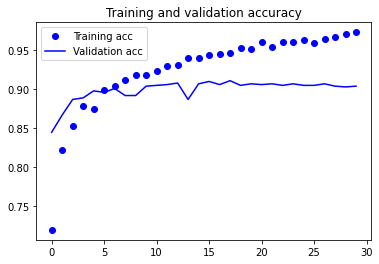

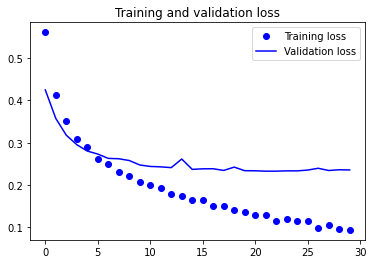

In [7]:
# 코드 5-19 결과 그래프 그리기
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 이전 절에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

## 2. 데이터 증식을 사용한 특성 추출

conv_base 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행합니다.

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다

케라스에서는 trainable 속성을 False로 설정하여 네트워크를 동결할 수 있습니다:

In [10]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [11]:
conv_base.trainable = False

In [12]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 22s - loss: 0.5634 - acc: 0.7175 - val_loss: 0.3201 - val_acc: 0.8440
Epoch 2/30
 - 20s - loss: 0.4129 - acc: 0.8255 - val_loss: 0.3680 - val_acc: 0.8340
Epoch 3/30
 - 19s - loss: 0.3525 - acc: 0.8550 - val_loss: 0.2504 - val_acc: 0.8890
Epoch 4/30
 - 19s - loss: 0.3232 - acc: 0.8655 - val_loss: 0.2666 - val_acc: 0.8950
Epoch 5/30
 - 19s - loss: 0.3030 - acc: 0.8765 - val_loss: 0.1183 - val_acc: 0.8910
Epoch 6/30
 - 19s - loss: 0.2881 - acc: 0.8885 - val_loss: 0.4483 - val_acc: 0.8970
Epoch 7/30
 - 19s - loss: 0.2813 - acc: 0.8835 - val_loss: 0.1617 - val_acc: 0.8990
Epoch 8/30
 - 19s - loss: 0.2714 - acc: 0.8880 - val_loss: 0.1058 - val_acc: 0.8940
Epoch 9/30
 - 19s - loss: 0.2588 - acc: 0.9015 - val_loss: 0.0441 - val_acc: 0.8950
Epoch 10/30
 - 19s - loss: 0.2480 - acc: 0.9055 - val_loss: 0.1421 - val_acc: 0.9020
Epoch 11/30
 - 19s - loss: 0.2433 - acc: 0.9050 - val_loss: 0.2072 - val_ac

In [14]:
model.save('cats_and_dogs_small_3.h5')

결과 그래프를 다시 그려 봅시다:

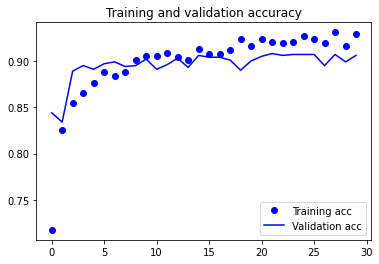

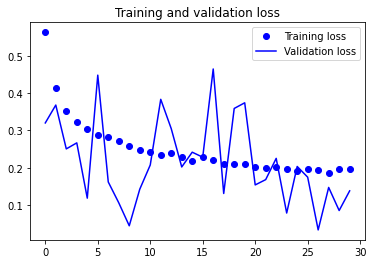

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

여기서 볼 수 있듯이 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.

## 미세 조정

미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

네트워크를 미세 조정하는 단계는 다음과 같습니다:

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

처음 세 단계는 특성 추출을 할 때 이미 완료했으므로 네 번째 단계를 진행합니다. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다.

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


block5_conv1, block5_conv2, block5_conv3 층은 학습 대상이 됩니다.

왜 더 많은 층을 미세 조정하지 않을까요? 왜 전체 합성곱 기반층을 미세 조정하지 않을까요? 그렇게 할 수도 있지만 다음 사항을 고려해야 합니다:

합성곱 기반층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면 상위 층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다. 하위 층으로 갈수록 미세 조정에 대한 효과가 감소합니다.
훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반층은 1천 5백만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.
그러므로 이런 상황에서는 합성곱 기반층에서 최상위 두 세개의 층만 미세 조정하는 것이 좋습니다.



In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 23s 225ms/step - loss: 0.1931 - acc: 0.9210 - val_loss: 0.1087 - val_acc: 0.9140
Epoch 2/100
100/100 [==============================] - 21s 206ms/step - loss: 0.1652 - acc: 0.9300 - val_loss: 0.1661 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 20s 204ms/step - loss: 0.1398 - acc: 0.9475 - val_loss: 0.0552 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 20s 204ms/step - loss: 0.1217 - acc: 0.9530 - val_loss: 0.0415 - val_acc: 0.9060
Epoch 5/100
100/100 [==============================] - 21s 206ms/step - loss: 0.1084 - acc: 0.9615 - val_loss: 0.1976 - val_acc: 0.9030
Epoch 6/100
100/100 [==============================] - 20s 204ms/step - loss: 0.0985 - acc: 0.9595 - val_loss: 0.4503 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 20s 205ms/step - loss: 0.0787 - acc: 0.9720 - val_loss: 0.2719 - val_acc: 0.9190
Epoch 8/100
100/100 [===========================

In [19]:
model.save('cats_and_dogs_small_4.h5')

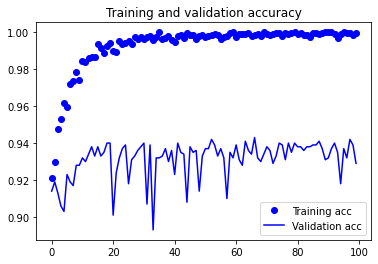

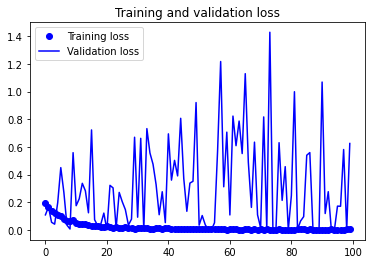

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프가 불규칙하게 보입니다. 그래프를 보기 쉽게하기 위해 지수 이동 평균으로 정확도와 손실 값을 부드럽게 표현할 수 있습니다.

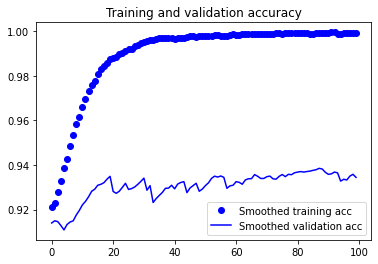

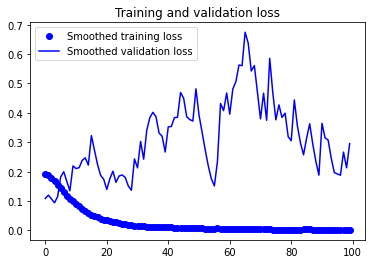

In [21]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9309999942779541


- 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.
- 작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
- 특성 추출 방식으로 새로운 데이터셋에 기존의 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.
- 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.